In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


file_path = 'I_V Sweep - Unit (transfer) [251203_ALD IGZO_#1_R1C0_40_20_1(1) _ 12_8_2025 11_46_59 AM].csv'
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if any(col.strip().startswith('DataValue') for col in line.split(',')):
        header_row = i - 2
        break
df = pd.read_csv(file_path,sep = ',', header = header_row)

df = df.iloc[:,1:]
df.columns = df.columns.str.strip()

df.head(10)

,VG,VD,VS,IG,ID,IS,SS,ICH
0,-3.00,0.1,0,-1.260000e-13,-4.000000e-14,-1.380000e-13,-33.519818007775577,-1.660000e-13
1,-2.95,0.1,0,-5.600000e-14,-9.000000e-15,-1.590000e-13,-195.7615188971227,-6.500000e-14
2,-2.90,0.1,0,-7.500000e-14,2.400000e-14,-1.730000e-13,-849.01870157034875,-5.100000e-14
3,-2.85,0.1,0,-7.000000e-14,-8.000000e-15,-1.470000e-13,390.72668946407867,-7.800000e-14
4,-2.80,0.1,0,-4.000000e-14,3.100000e-14,-1.300000e-13,75.656938274876637,-9.000000e-15
5,-2.75,0.1,0,-3.300000e-14,-3.000000e-14,-1.370000e-13,1599.4790309635521,-6.300000e-14
6,-2.70,0.1,0,-3.900000e-14,-3.300000e-14,-1.660000e-13,126.82994037090332,-7.200000e-14
7,-2.65,0.1,0,-7.300000e-14,-6.600000e-14,-1.910000e-13,-773.923535073706,-1.390000e-13
8,-2.60,0.1,0,-4.900000e-14,-2.900000e-14,-1.400000e-13,-38.756432735848634,-7.800000e-14
9,-2.55,0.1,0,-6.400000e-14,-5.000000e-15,-1.330000e-13,198.4500334311812,-6.900000e-14


In [13]:
## data 제대로 들어왔는지 확인

In [4]:
df['ID'] = df['ID'].abs()
df['ID'] = np.clip(df['ID'], 1e-16, None)

df.value_counts()
df.describe()
row_counts = df.shape[0]

for i in df.columns:
    empty = df[i].isna().sum()
    print(f'{i} column에서 빈값은 {empty}개임.')

VG column에서 빈값은 0개임.
VD column에서 빈값은 0개임.
VS column에서 빈값은 0개임.
IG column에서 빈값은 0개임.
ID column에서 빈값은 0개임.
IS column에서 빈값은 0개임.
SS column에서 빈값은 0개임.
ICH column에서 빈값은 0개임.


In [5]:
# graph plot

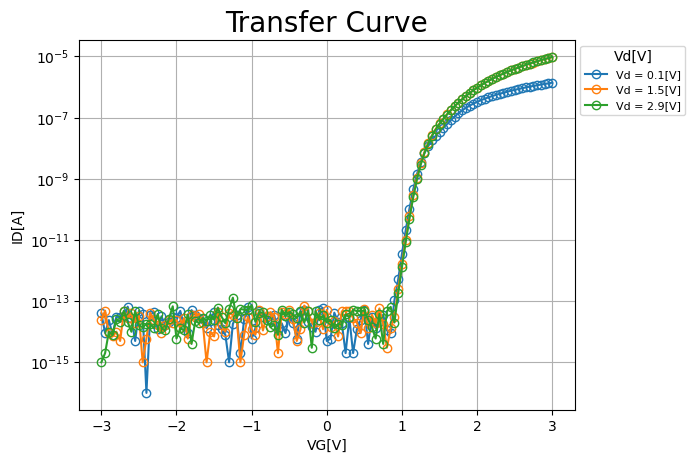

In [6]:
fig, ax  = plt.subplots()
for VD, g in df.groupby('VD'):
    plt.semilogy(g['VG'],g['ID'],marker = 'o',markerfacecolor = 'none',label = f'Vd = {VD}[V]')

ax.set_xlabel('VG[V]')
ax.set_ylabel('ID[A]')
ax.set_title('Transfer Curve', fontsize = 20)
ax.legend(title = 'Vd[V]',bbox_to_anchor = (1,1),loc = 'upper left',fontsize = 8)
ax.grid(True)


In [7]:
# Vth 구하기

In [8]:
target1 = -10                               # log(ID) = -10이 타겟임(vth 산출용)
target2 = -9                                # SS 산출용
vth_by_vd_10 = {}  # VD별 Vth 저장
vth_by_vd_9 = {}  # VD별 Vth 저장
for vd, g in df.groupby('VD'):              # 앞에 있는 vd는 df.groupby('VD')의 key인 'VD'를 받는것이고 뒤에 있는 g는 key 'VD'에 해당하는 값을 받는다.
    g = g.sort_values('ID')

    VG = g['VG'].to_numpy()                 # VG column을 숫자로 변환
    ID = g['ID'].to_numpy()                 # ID column을 숫자로 변환

    # log10(|ID|) 계산: 0은 로그 불가 → 아주 작은 값으로 클리핑
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)   # underflow 방지
    logI = np.log10(absID)

     # ===== 3) target 교차 구간 탐색 + 선형 보간 =====
    diff1 = logI - target1
    diff2 = logI - target2
    cross_idx_10 = np.where(diff1[:-1] * diff1[1:] <= 0)[0]  # target을 사이에 두는 인접 점(★★★★★★★★★★★★ np.where(condition,True,False))
    cross_idx_9 = np.where(diff2[:-1] * diff2[1:] <= 0)[0] 

    if len(cross_idx_10) == 0:
        vth_by_vd_10[vd] = np.nan
        continue
    if len(cross_idx_9) == 0:
        vth_by_vd_9[vd] = np.nan
        continue
    # 첫 번째 crossing 사용 (원하면 마지막 crossing: cross_idx[-1])
    i1 = cross_idx_10[0]
    i2 = cross_idx_9[0]

    x0, x1 = VG[i1], VG[i1+1]
    y0, y1 = logI[i1], logI[i1+1]

    z0, z1 = VG[i2], VG[i2+1]
    t0, t1 = logI[i2], logI[i2+1]    

    # 분모 0 방지
    if y1 == y0:
        vth_10 = np.nan
    else:
        vth_10 = x0 + (target1 - y0) * (x1 - x0) / (y1 - y0)

    vth_by_vd_10[vd] = vth_10
    
    # 분모 0 방지
    if t1 == t0:
        vth_9 = np.nan
    else:
        vth_9 = z0 + (target2 - t0) * (z1 - z0) / (t1 - t0)

    vth_by_vd_9[vd] = vth_9
    
# ===== 5) VD별 Vth 출력 =====
print(f"Vth @ log10(|ID|) = {target1} (by VD)")
for vd in sorted(vth_by_vd_10.keys()):
    print(f"VD={vd}: Vth={vth_by_vd_10[vd]}")

    # ===== 6) VD별 SS 계산 =====
ss_by_vd = {}  # VD별 SS 저장 (mV/dec)

for vd in vth_by_vd_10.keys():
    vg_at_10 = vth_by_vd_10.get(vd, np.nan)  # log|ID|=-10에서 VG
    vg_at_9  = vth_by_vd_9.get(vd, np.nan)   # log|ID|=-9에서 VG

    # 둘 중 하나라도 NaN이면 SS도 NaN
    if np.isnan(vg_at_10) or np.isnan(vg_at_9):
        ss_by_vd[vd] = np.nan
    else:
        ss_v_per_dec = (vg_at_9 - vg_at_10) / (target2 - target1)  # 여기서는 /1이라 동일하지만 일반식으로 작성
        ss_by_vd[vd] = ss_v_per_dec * 1000  # mV/dec

# ===== 7) VD별 SS 출력 =====
print(f"SS (mV/dec) using log10(|ID|)={target1} to {target2} (by VD)")
for vd in sorted(ss_by_vd.keys()):
    print(f"VD={vd}: SS={ss_by_vd[vd]}")



Vth @ log10(|ID|) = -10 (by VD)
VD=0.1: Vth=1.09819211635889
VD=1.5: Vth=1.116883160960979
VD=2.9: Vth=1.12161599253323
SS (mV/dec) using log10(|ID|)=-10 to -9 (by VD)
VD=0.1: SS=86.64482292563424
VD=1.5: SS=80.18774969402887
VD=2.9: SS=79.68217457566573
